In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from src.datalib import *
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import skimage
import os
import pandas

from tqdm import tqdm
%matplotlib widget

In [3]:
wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

def min_max(arr):
    return  abs( (arr - arr.min()) / (arr.max() - arr.min()) )#.astype(np.uint8)

# 1. Load LIBS Dataset

In [4]:
file_libs_metadata = r'F:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"F:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines


In [5]:
libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

getting map dimensions


# 2. Load ICP-MS Data

['F:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']
['F:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']
['F:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']


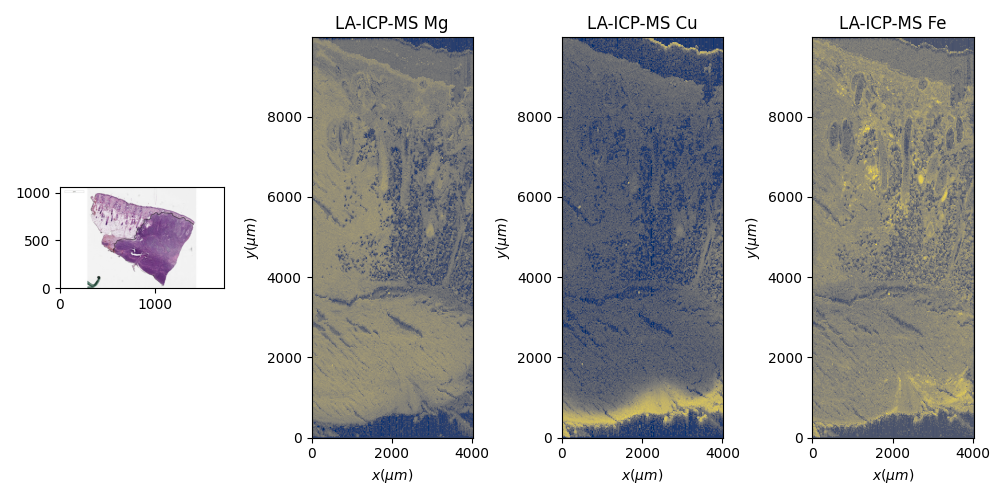

In [6]:
main_dir = r"F:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_ICP = main_dir + sample_dir + r"LA-ICP-MS//P36B//Export//"
dir_image = main_dir + sample_dir + r"Histology//"
dir_LIBS = main_dir + sample_dir + r'LIBS//'


def read_image(folder,index=0):
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('jpg')]
    return skimage.io.imread(files[index])

def read_metadata(file1):
    df = pandas.read_csv(file1,encoding = "ISO-8859-1",header=None)
    map_dims = [float(df[1][0].split('x')[0]),float(df[1][0].split('x')[1])]
    spot_dims = [float(df[1][1].split('x')[0]),float(df[1][1].split('x')[1])]
    return map_dims, spot_dims

def read_icp(folder, name='Total'):
    file1 = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and 'metadata' in f]
    print(file1)
    map_dims, spot_dims = read_metadata(file1[0])
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and name in f]
    df = pandas.read_csv(files[0],encoding = "ISO-8859-1",header=None)
    df = df.fillna(0)
    data = df.to_numpy()
    data-=data.min()+1
    return map_dims, spot_dims, data

names_ICP = ['Mg','Cu','Fe']
n_ICP = len(names_ICP)
data_ICP = []
for i in range(0, n_ICP):
    map_dims, spot_dims, data = read_icp(dir_ICP,name=names_ICP[i])
    data_ICP.append(data)

fig, ax = plt.subplots(1,1+n_ICP,figsize=[10,5])

sample_image = read_image(dir_image)
ax[0].imshow(sample_image,origin='lower')

for i in range(0, n_ICP):
    ax[i+1].imshow(data_ICP[i], norm = colors.LogNorm(vmin = 10, vmax=data.max()), cmap = 'cividis', extent=[0,map_dims[0],0,map_dims[1]])
    ax[i+1].set_xlabel(r'$x (\mu m)$')
    ax[i+1].set_ylabel(r'$y (\mu m)$')
    ax[i+1].set_title('LA-ICP-MS '+ str(names_ICP[i]))

fig.tight_layout()

# 3. Attemp Alignment

## 3.1 Get the two images we will align

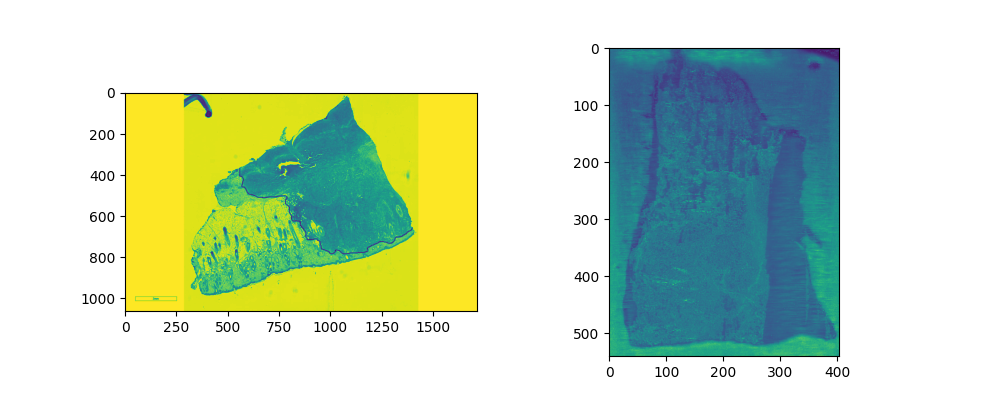

In [7]:
im_i = sample_image[:, :, 0]/255 # RGB
im_j = min_max(spectrum[:, :, wavelength_to_index(266.106, wavelengths)]) # LIBS

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.imshow(im_i[:, :])

ax = axs[1]
ax.imshow(im_j)

## 3.2 Build Guassian Pyramids

Final transformation parameters: [-3.5609262   0.00609817  1.4662317   1.4571352   2.612128  ]


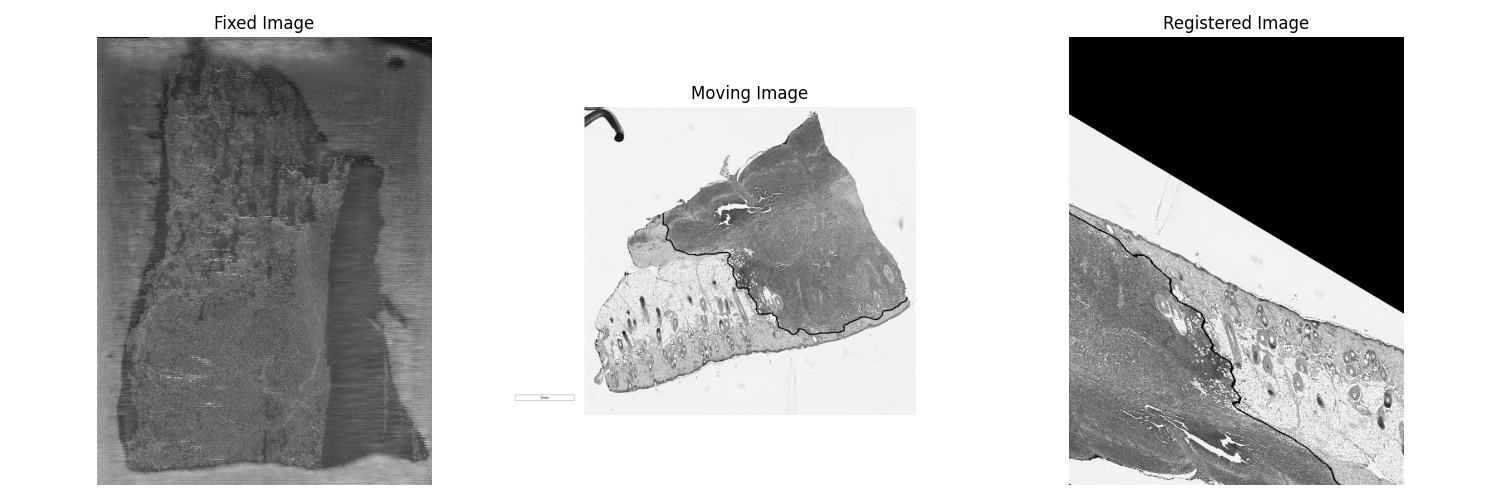

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt



class MultiscaleImageRegistration:
    def __init__(self, fixed, moving, levels, iterations, learning_rate):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fixed = self.preprocess(fixed)
        self.moving = self.preprocess(moving)
        self.levels = levels
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.fixed_shape = fixed.shape[-2:]
        self.moving_shape = moving.shape[-2:]

    def preprocess(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()
        if image.dim() == 2:
            image = image.unsqueeze(0).unsqueeze(0)
        elif image.dim() == 3:
            image = image.unsqueeze(0)
        return image.to(self.device)

    def create_pyramid(self, image):
        pyramid = [image]
        for _ in range(self.levels - 1):
            pyramid.append(F.avg_pool2d(pyramid[-1], 2))
        return pyramid[::-1]  # Coarsest to finest

    def mutual_information(self, x, y, sigma=0.4, bins=20):
        # Ensure x and y are 2D tensors
        x = x.view(-1, 1)
        y = y.view(-1, 1)

        # Normalize the values of x and y
        min_val = torch.min(x.min(), y.min())
        max_val = torch.max(x.max(), y.max())
        
        x = (x - min_val) / (max_val - min_val)
        y = (y - min_val) / (max_val - min_val)

        # Create smooth bin centers
        bin_centers = torch.linspace(0, 1, bins, device=self.device)

        # Apply a Gaussian kernel density estimate
        x_kernel = torch.exp(-((x - bin_centers.view(1, -1)) ** 2) / (2 * sigma ** 2))
        y_kernel = torch.exp(-((y - bin_centers.view(1, -1)) ** 2) / (2 * sigma ** 2))

        # Estimate the probability distributions
        px = x_kernel.mean(dim=0)
        py = y_kernel.mean(dim=0)
        pxy = torch.mm(x_kernel.t(), y_kernel) / x.shape[0]

        # Add a small constant to avoid log(0)
        pxy_plus = pxy + 1e-10
        px_plus = px.unsqueeze(1) + 1e-10
        py_plus = py.unsqueeze(0) + 1e-10

        # Calculate mutual information
        mi = torch.sum(pxy_plus * torch.log(pxy_plus / (px_plus * py_plus)))
        return mi

    # def simple_test_loss(self, x, y):
    #     # Simple Mean Squared Error to test gradient flow
    #     loss = torch.mean((x - y) ** 2)
    #     print(f"Simple Test Loss Value: {loss.item()}, grad_fn: {loss.grad_fn}")  # This should not be None
    #     return loss

    def affine_transform(self, image, params, target_shape):
        rotation, tx, ty, sx, sy = params
        
        # Calculate scaling factors to account for different image sizes
        h_ratio = target_shape[-2] / image.shape[-2]
        w_ratio = target_shape[-1] / image.shape[-1]
        
        # Adjust scaling parameters
        sx = sx * w_ratio
        sy = sy * h_ratio
        
        # Adjust translation parameters
        tx = tx * w_ratio
        ty = ty * h_ratio

        cos_theta = torch.cos(rotation)
        sin_theta = torch.sin(rotation)
        
        theta = torch.stack([
            sx * cos_theta, -sx * sin_theta, tx,
            sy * sin_theta, sy * cos_theta, ty
        ]).view(1, 2, 3)

        grid = F.affine_grid(theta, [1, 1, target_shape[-2], target_shape[-1]], align_corners=False)
        transformed_image = F.grid_sample(image, grid, align_corners=False, mode='bilinear')

        return transformed_image

    def register(self):
        fixed_pyramid = self.create_pyramid(self.fixed)
        moving_pyramid = self.create_pyramid(self.moving)

        # Initialize parameters with scale based on initial size difference
        initial_sx = self.fixed_shape[1] / self.moving_shape[1]
        initial_sy = self.fixed_shape[0] / self.moving_shape[0]
        params = torch.tensor([0.0, 0.0, 0.0, initial_sx, initial_sy], device=self.device, requires_grad=True)

        for level in range(self.levels):
            fixed_img = fixed_pyramid[level]
            moving_img = moving_pyramid[level]

            optimizer = torch.optim.Adam([params], lr=self.learning_rate)

            for _ in range(self.iterations):
                optimizer.zero_grad()

                transformed = self.affine_transform(moving_img, params, fixed_img.shape[-2:])
                loss = -self.mutual_information(fixed_img.flatten(), transformed.flatten())
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    params[3:] = torch.clamp(params[3:], min=0.1, max=10)

            self.learning_rate *= 0.5

        return params.detach().cpu().numpy()


    def apply_transform(self, params):
        target_shape = self.fixed.shape  # Use the shape of the fixed image
        transformed_image = self.affine_transform(self.moving, torch.tensor(params, device=self.device), target_shape)
        return transformed_image.squeeze().cpu().numpy()

    def visualize_results(self, params):
        fixed_np = self.fixed.squeeze().cpu().numpy()
        moving_np = self.moving.squeeze().cpu().numpy()
        registered_np = self.apply_transform(params)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(fixed_np, cmap='gray')
        axes[0].set_title('Fixed Image')
        axes[1].imshow(moving_np, cmap='gray')
        axes[1].set_title('Moving Image')
        axes[2].imshow(registered_np, cmap='gray')
        axes[2].set_title('Registered Image')
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()

levels = 3
iterations = 1000
lr = 0.1

registration = MultiscaleImageRegistration(im_j, im_i, levels = levels, iterations = iterations, learning_rate = lr)
params = registration.register()
print("Final transformation parameters:", params)
registration.visualize_results(params)